# Machine Learning with Large Datasets
## Modeling with the Million Songs Database using AWS and Spark

Million songs data is stored in an S3 bucket already. This file will be run on an AWS Elastic MapReduce instance.

### 0. Start a Spark Session and Install Libraries

In [1]:
# You are highly recommended to select the "PySpark" kernel instead of python kernel,
# Otherwise you need to modify this cell to get pyspark working.

from pyspark.sql import *

sc = spark.sparkContext
print(f'num executors: {sc.getConf().get("spark.executor.instances")}')

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1710798701121_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

num executors: 1

In [2]:
import matplotlib.pyplot as plt
import numpy as np
'''
Note : If you are having issues with your plots not showing, try running `%matplot plt` in a new code box after you have run the rest of the plotting code.
'''

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'\nNote : If you are having issues with your plots not showing, try running `%matplot plt` in a new code box after you have run the rest of the plotting code.\n'

### 1. Data Loading and Preparation

Earlier, we have extracted relevant features from and converted format of the full raw Million Song Dataset. We now want to load our converted dataset from the S3 Storage.

Note that although you can load all chunks of the dataset using `*`, we recommend you only load in a subset while developing so that processing takes shorter time when you are just verifying your ideas. Be sure to add your own S3 bucket name to cmd 8.

In [3]:
from pyspark.sql.types import DoubleType, StringType, StructField, StructType

schema = StructType([StructField('song_hotttnesss', DoubleType(), True),
                       StructField('artist_familiarity', DoubleType(), True),
                       StructField('artist_hotttnesss', DoubleType(), True),
                       StructField('artist_id', StringType(), True),
                       StructField('artist_latitude', DoubleType(), True),
                       StructField('artist_location', StringType(), True),
                       StructField('artist_longitude', DoubleType(), True),
                       StructField('artist_name', StringType(), True),
                       StructField('title', StringType(), True),
                       StructField('danceability', DoubleType(), True),
                       StructField('duration', DoubleType(), True),
                       StructField('end_of_fade_in', DoubleType(), True),
                       StructField('energy', DoubleType(), True),
                       StructField('key', DoubleType(), True),
                       StructField('key_confidence', DoubleType(), True),
                       StructField('loudness', DoubleType(), True),
                       StructField('mode', DoubleType(), True),
                       StructField('mode_confidence', DoubleType(), True),
                       StructField('start_of_fade_out', DoubleType(), True),
                       StructField('tempo', DoubleType(), True),
                       StructField('time_signature', DoubleType(), True),
                       StructField('time_signature_confidence', DoubleType(), True),
                       StructField('artist_terms', StringType(), True),
                       StructField('artist_terms_freq', StringType(), True),
                       StructField('artist_terms_weight', StringType(), True),
                       StructField('year', DoubleType(), True)]
                   )

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
#--------------------------------------------------------------------
#Set to False after writing your code and run end-to-end on full data
#--------------------------------------------------------------------
load_subset = True
#----------------------------
#Add your s3 bucket name below:
#----------------------------
s3_bucket_name = ''

if load_subset:
    df = spark.read.format("csv")\
        .option("header", "false")\
        .option("nanValue", "nan")\
        .option("quote", "\"")\
        .option("escape", "\"")\
        .schema(schema)\
        .load(f"s3://{s3_bucket_name}/processed/A_1.csv")
else:
    df = spark.read.format("csv")\
        .option("header", "false")\
        .option("nanValue", "nan")\
        .option("quote", "\"")\
        .option("escape", "\"")\
        .schema(schema)\
        .load(f"s3://{s3_bucket_name}/processed/*.csv")

print('loaded {} records'.format(df.count()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

loaded 581965 records

Inspect the `df` we just created by running the below cell:

In [5]:
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- song_hotttnesss: double (nullable = true)
 |-- artist_familiarity: double (nullable = true)
 |-- artist_hotttnesss: double (nullable = true)
 |-- artist_id: string (nullable = true)
 |-- artist_latitude: double (nullable = true)
 |-- artist_location: string (nullable = true)
 |-- artist_longitude: double (nullable = true)
 |-- artist_name: string (nullable = true)
 |-- title: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- duration: double (nullable = true)
 |-- end_of_fade_in: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: double (nullable = true)
 |-- key_confidence: double (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: double (nullable = true)
 |-- mode_confidence: double (nullable = true)
 |-- start_of_fade_out: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- time_signature_confidence: double (nullable = true)
 |-- artist_terms: string

### 2. Exploratory Data Analysis

Now we have our data mostly ready. It's a good time to take some deeper look to better understand what we are dealing with here.

In [6]:
df.summary().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------------+------------------+------------------+------------------+---------------+------------------+----------------+-----------+--------------------+------------+------------------+------------------+------+-----------------+-------------------+------------------+-------------------+-------------------+------------------+-----------------+-----------------+-------------------------+--------------------+-----------------+--------------------+------------------+
|summary|    song_hotttnesss|artist_familiarity| artist_hotttnesss|         artist_id|artist_latitude|   artist_location|artist_longitude|artist_name|               title|danceability|          duration|    end_of_fade_in|energy|              key|     key_confidence|          loudness|               mode|    mode_confidence| start_of_fade_out|            tempo|   time_signature|time_signature_confidence|        artist_terms|artist_terms_freq| artist_terms_weight|              year|
+-------+-----------------

Now we would like to make some histogram plots to inspect the distribution of feature values. 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

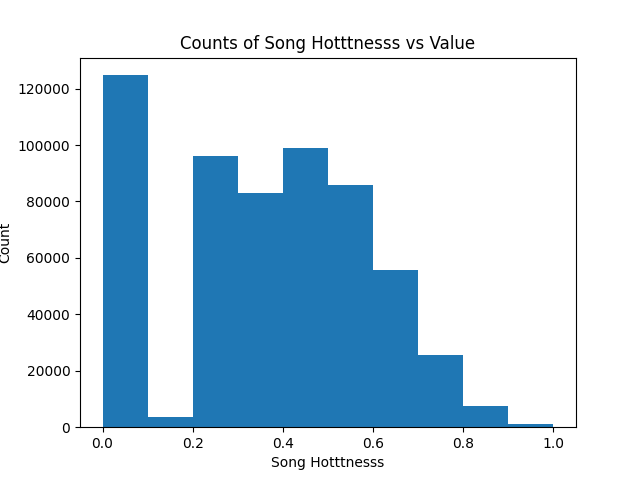

In [7]:
plt.clf()
plt.hist(df.select('song_hotttnesss').rdd.flatMap(lambda x: x).collect())
plt.title('Counts of Song Hotttnesss vs Value')
plt.xlabel('Song Hotttnesss')
plt.ylabel('Count')
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

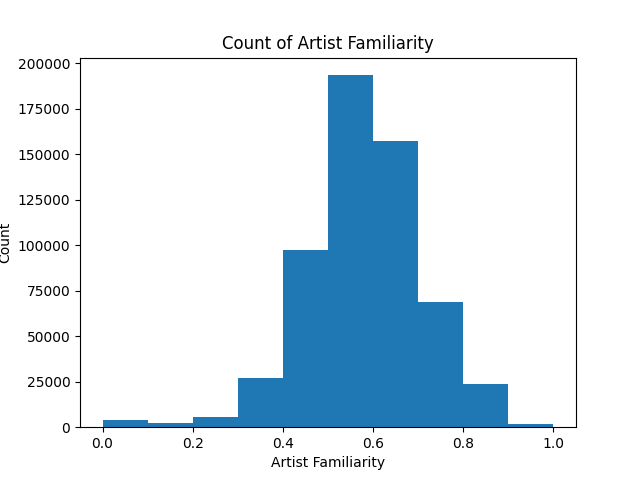

In [8]:
plt.clf()
plt.hist(df.select('artist_familiarity').rdd.flatMap(lambda x: x).collect())
plt.title('Count of Artist Familiarity')
plt.xlabel('Artist Familiarity')
plt.ylabel('Count')
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

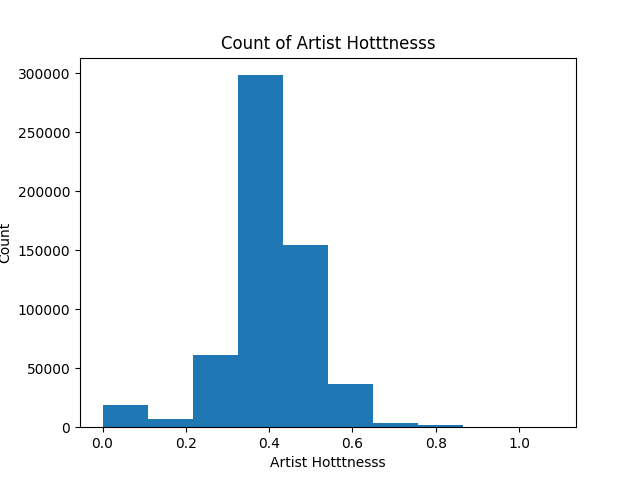

In [9]:
plt.clf()
plt.hist(df.select('artist_hotttnesss').rdd.flatMap(lambda x: x).collect())
plt.title('Count of Artist Hotttnesss')
plt.xlabel('Artist Hotttnesss')
plt.ylabel('Count')
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

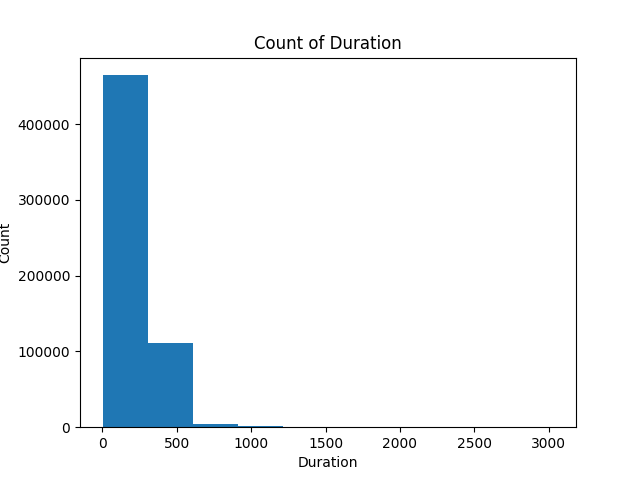

In [10]:
plt.clf()
plt.hist(df.select('duration').rdd.flatMap(lambda x: x).collect())
plt.title('Count of Duration')
plt.xlabel('Duration')
plt.ylabel('Count')
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

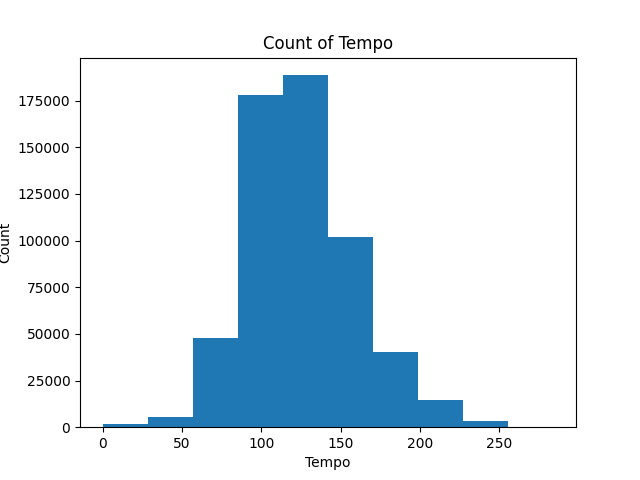

In [11]:
plt.clf()
plt.hist(df.select('tempo').rdd.flatMap(lambda x: x).collect())
plt.title('Count of Tempo')
plt.xlabel('Tempo')
plt.ylabel('Count')
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

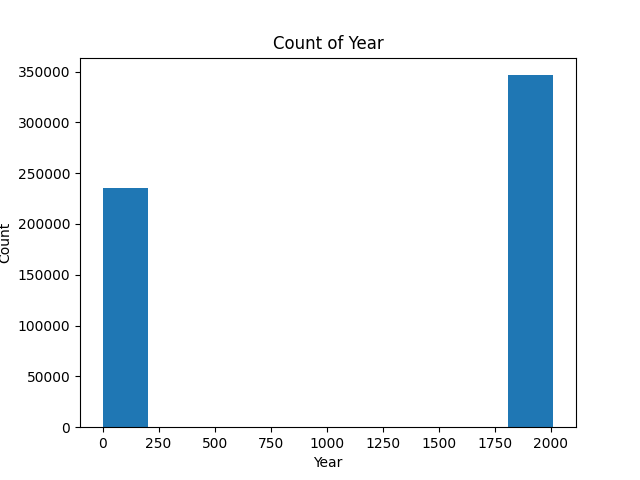

In [12]:
plt.clf()
plt.hist(df.select('year').rdd.flatMap(lambda x: x).collect())
plt.title('Count of Year')
plt.xlabel('Year')
plt.ylabel('Count')
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

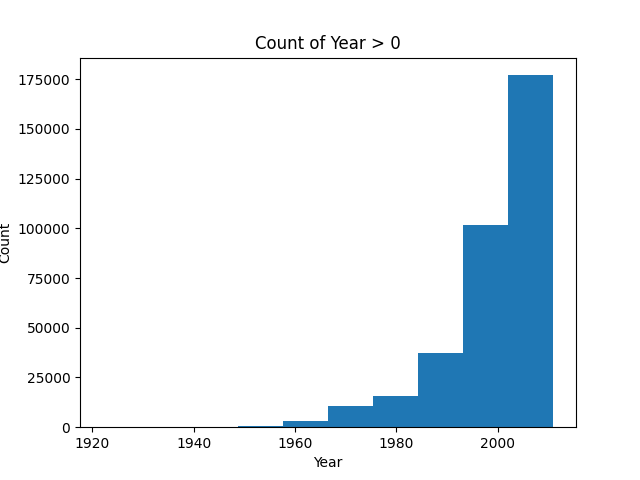

In [13]:
plt.clf()
filtered_df = df.filter(df['year'] != 0)
plt.hist(filtered_df.select('year').rdd.flatMap(lambda x: x).collect())
plt.title('Count of Year > 0')
plt.xlabel('Year')
plt.ylabel('Count')

%matplot plt

Some scatter pair plots would also be interesting to see the correlation between features. ✰2.3(e) Include the plots of the following pairs of features and describe your findings (e.g. what patterns you observe) in your writeup.
- `song_hotttnesss` against `artist_familiarity`
- `artist_latitude` against `artist_longitude`
- `song_hotttnesss` against `year`

Plotting all data points might explode matplotlib. Think about what simple technique you could use to visualize large datasets while retaining data distribution. ✰2.3(f) In your writeup, briefly describe what you did.

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

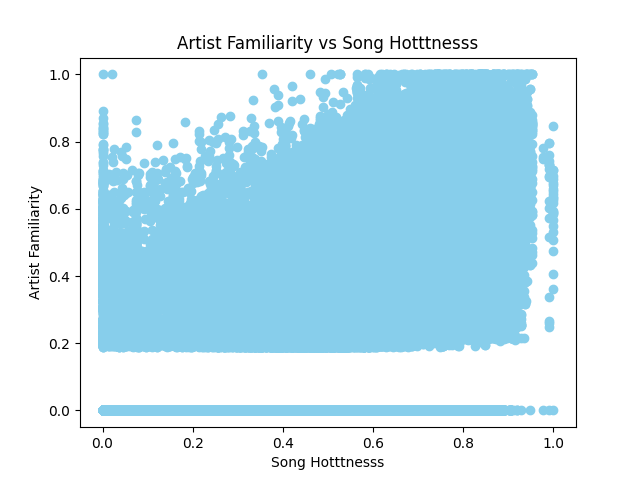

In [14]:
plt.clf()
column1_values = df.select('song_hotttnesss').rdd.flatMap(lambda x: x).collect()
column2_values = df.select('artist_familiarity').rdd.flatMap(lambda x: x).collect()
plt.title('Artist Familiarity vs Song Hotttnesss')
plt.xlabel('Song Hotttnesss')
plt.ylabel('Artist Familiarity')

plt.scatter(column2_values, column1_values, color='skyblue')
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

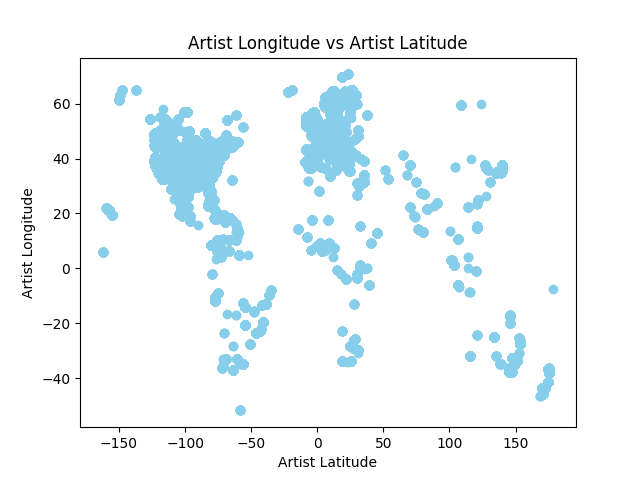

In [15]:
plt.clf()
column1_values = df.select('artist_latitude').rdd.flatMap(lambda x: x).collect()
column2_values = df.select('artist_longitude').rdd.flatMap(lambda x: x).collect()
plt.title('Artist Longitude vs Artist Latitude')
plt.xlabel('Artist Latitude')
plt.ylabel('Artist Longitude')

plt.scatter(column2_values, column1_values, color='skyblue')
%matplot plt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

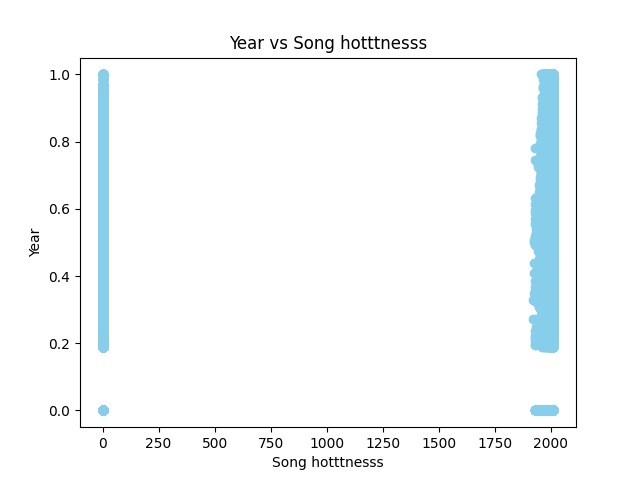

In [16]:
plt.clf()
column1_values = df.select('song_hotttnesss').rdd.flatMap(lambda x: x).collect()
column2_values = df.select('year').rdd.flatMap(lambda x: x).collect()
plt.title('Year vs Song hotttnesss')
plt.xlabel('Song hotttnesss')
plt.ylabel('Year')

plt.scatter( column2_values, column1_values, color='skyblue')
%matplot plt

### 3. Data Cleaning

From 2, you should have had a basic understanding of the dataset. In this cleaning step, we are dropping `energy` and `danceability` features. 

In [17]:
columns_to_drop = ['energy', 'danceability']

cleaned_df = df.drop(*columns_to_drop)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

For simplicity, we are dropping `year` values that are less or equal to 1920.

In [18]:
print(cleaned_df.count())
cleaned_df = cleaned_df.filter(df['year'] > 1920)
print(cleaned_df.count())

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

581965
346444

Now, let's do an NaN check to see if there are other problematic features.

In [19]:
# count na
from pyspark.sql.functions import isnan, when, count, isnull

for column in cleaned_df.columns:
    nan_count = cleaned_df.select(count(when(isnan(column), column))).collect()[0][0]
    print(f"NaN count for {column}: {nan_count}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NaN count for song_hotttnesss: 0
NaN count for artist_familiarity: 1
NaN count for artist_hotttnesss: 0
NaN count for artist_id: 0
NaN count for artist_latitude: 219399
NaN count for artist_location: 0
NaN count for artist_longitude: 219399
NaN count for artist_name: 0
NaN count for title: 1
NaN count for duration: 0
NaN count for end_of_fade_in: 0
NaN count for key: 0
NaN count for key_confidence: 0
NaN count for loudness: 0
NaN count for mode: 0
NaN count for mode_confidence: 0
NaN count for start_of_fade_out: 0
NaN count for tempo: 0
NaN count for time_signature: 0
NaN count for time_signature_confidence: 0
NaN count for artist_terms: 0
NaN count for artist_terms_freq: 0
NaN count for artist_terms_weight: 0
NaN count for year: 0

We should see two features that contain (a lot of) `nan` in them.

For simplicity, we are dropping all records with `nan` in these two features. Note that this drops a significant proportion of our dataset. Since we have a lot of data to fit some rather simple models, this might be ok. 

However, do note that this is not usually desirable in the real-word because we always want to retain as much data as possible, especially when training larger, more complex models.

In [20]:
cleaned_df = cleaned_df.filter(~isnan(df['artist_latitude']))
cleaned_df = cleaned_df.filter(~isnan(df['artist_longitude']))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Lets calcualte the percentage of records that survived this very aggressive data cleaning.

In [21]:
# counting code
print((cleaned_df.count() / df.count()) * 100)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

21.830350622460113

### 4. Baseline

Now we have the data (almost) ready to do some preliminary modeling! 

We will be treating this problem as a classification problem, i.e. given some features, predict whether a song will be popular. We define a song to be popular if its `song_hotttnesss` value is above average.

In [22]:
from pyspark.sql.functions import col, expr, when, avg

# assign labels
average_hotttness = cleaned_df.select(avg('song_hotttnesss')).collect()[0][0]
df_with_label = cleaned_df.withColumn('label', when(col('song_hotttnesss') > average_hotttness, 1).otherwise(0))
df_with_label.select("label").summary().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-------------------+
|summary|              label|
+-------+-------------------+
|  count|             127045|
|   mean| 0.5599354559408084|
| stddev|0.49639669687421617|
|    min|                  0|
|    25%|                  0|
|    50%|                  1|
|    75%|                  1|
|    max|                  1|
+-------+-------------------+

Now let's take a look at how balanced the two classes are.

In [23]:
total_rows = df_with_label.count()
popular_songs_count = df_with_label.filter(df_with_label['label'] == 1).count()
popular_percentage = (popular_songs_count / total_rows) * 100
popular_percentage

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

55.99354559408084

In [24]:
print(average_hotttness)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.4271275159918469

As how we've been dealing with the `year` feature in earlier assignments, we will shift the feature so that it starts from 0.

In [25]:
# shift years
from pyspark.sql.functions import min
min_year = df_with_label.select(min('year')).first()[0]
df_shifted_year = df_with_label.withColumn('year', col('year') - min_year)
df_shifted_year.select("year").summary().show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+
|summary|             year|
+-------+-----------------+
|  count|           127045|
|   mean| 73.9572907237593|
| stddev|10.85533555585107|
|    min|              0.0|
|    25%|             70.0|
|    50%|             77.0|
|    75%|             82.0|
|    max|             86.0|
+-------+-----------------+

Finally, let's concatenate all features (using VectorAssembler) into a feature vector and scale it. 

Note: we will only be using the numeric features for now. Excluding `song_hotttnesss` and the two features we dropped in the data cleaning step, there should be 19-3=16 of them.

In [26]:
# assembling vector

from pyspark.ml.feature import VectorAssembler
labels = df_shifted_year.select("label")
columns_to_drop = ["label", "artist_id", "artist_location", "artist_name", "title", "artist_terms", "artist_terms_freq", "artist_terms_weight", "song_hotttnesss"]
feature_columns = df_shifted_year.drop(*columns_to_drop).columns
print(len(feature_columns))

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_assembled = assembler.transform(df_shifted_year)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

16

In [27]:
# scaling

from pyspark.ml.feature import StandardScaler

scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_features = scaler_model.transform(df_assembled)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now let's verify the resulting feature vector is of expected length 16.

In [28]:
# change your variable/column names accordingly
l = df_features.select('features').take(1)[0].features
print('vector len:',len(l))
assert len(l) == 16

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

vector len: 16

Now, we are really ready to fit some models. 

First, do a train-test split on the dataset, with test ratio 0.2 and seed 10605.

In [29]:
train_df, test_df = df_features.randomSplit([0.8, 0.2], seed=10605)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We have to select a metric to evaluate our models on. For classification, potential choices include accuracy and AUC.

We will be going with AUC here. Instantiate an AUC Evaluator in the following cell.

In [30]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

auc_eval = BinaryClassificationEvaluator(metricName='areaUnderROC')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

We will be fitting two models, logistic regression, and random forest.

Train a LR and a RF model with default hyperparameters.

In [31]:
# Logistic Regression
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="label", featuresCol="scaled_features")
lr_model_basic = lr.fit(train_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [32]:
lr_train_predictions = lr_model_basic.transform(train_df)
lr_test_predictions = lr_model_basic.transform(test_df)
lr_train_auc = auc_eval.evaluate(lr_train_predictions)
lr_test_auc = auc_eval.evaluate(lr_test_predictions)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
lr_train_auc, lr_test_auc

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.7548546055180058, 0.7537922064276091)

In [34]:
# Random Forest

from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features")
rf_model_basic = rf.fit(train_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
rf_train_predictions = rf_model_basic.transform(train_df)
rf_test_predictions = rf_model_basic.transform(test_df)
rf_train_auc = auc_eval.evaluate(rf_train_predictions)
rf_test_auc = auc_eval.evaluate(rf_test_predictions)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
rf_train_auc, rf_test_auc

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.7637393898401477, 0.7621528652779781)

### 5. Featurization: Bag-of-Words and TF-IDF

In our list of features, we have two features that contain text data, namely `title` and `artist_terms`.

To get myself familiar with both in Spark, let's treat titles and artist terms as mini documents and compute TF-IDF for `title` and BoW for `artist_terms`.

In [37]:
# tf-idf on title

from pyspark.ml.feature import Tokenizer, HashingTF, IDF

TF_IDF_NUM_FEATS = 5 # HashingTF(..., numFeatures=TF_IDF_NUM_FEATS)

tokenizer = Tokenizer(inputCol="title", outputCol="title_token")
token_df = tokenizer.transform(df_shifted_year)

hashing_tf = HashingTF(inputCol="title_token", outputCol="title_hash", numFeatures=TF_IDF_NUM_FEATS)
hashed_df = hashing_tf.transform(token_df)

idf = IDF(inputCol="title_hash", outputCol="title_features")
idf_model = idf.fit(hashed_df)
df_tf_idf = idf_model.transform(hashed_df)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Verify the resulting TF-IDF feature is indeed a vector of length `TF_IDF_NUM_FEATS`.

In [38]:
from pyspark.ml.linalg import SparseVector
# change variable/column name to yours
col_name = 'title_features'
head = df_tf_idf.select(col_name).head() 
print(head)
assert type(head[col_name]) == SparseVector
assert len(head[col_name]) == TF_IDF_NUM_FEATS

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(title_features=SparseVector(5, {1: 0.8022, 2: 0.6637, 3: 0.696}))

Recall that `artist_terms` should be of type string array but we have not yet interpreted from a string literal. Let's do that now. 

In [39]:
from pyspark.sql.functions import udf
import pyspark.sql.types as T

def to_array(string):
    return string.split(',')

udf = udf(to_array, T.ArrayType(T.StringType()))

df_tags_arr = df_tf_idf.withColumn("artist_terms_arr", udf(df_tf_idf["artist_terms"]))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Let's do a quick check things indeed worked out.

In [40]:
# change to your variable/column names
col_name = 'artist_terms_arr'
head = df_tags_arr.select(col_name).head()
print(head)
assert type(head[col_name]) == list

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist_terms_arr=["['hardcore punk'", " 'heavy metal'", " 'hardcore metal'", " 'thrash core'", " 'hard rock'", " 'death core'", " 'crossover thrash'", " 'metalcore'", " 'nu metal'", " 'rock'", " 'melodic black metal'", " 'thrash metal'", " 'hardcore'", " 'melodic death metal'", " 'power metal'", " 'screamo'", " 'progressive metal'", " 'black metal'", " 'punk'", " 'emo'", " 'death metal'", " 'hip hop'", " 'rap'", " 'alternative rock'", " 'punk metal'", " 'united states'", " 'singer-songwriter'", " 'metal'", " 'american'", " 'new york hardcore'", " 'alternative'", " 'germany'", " 'indie'", " 'christian'", " '00s'", " 'heavy'", " 'new york'", " 'crossover'", " 'new york city'", " 'old school hardcore'", " 'drums'", " 'trash metal'", " 'beat down']"])

Now perform BoW on the array feature you just created.

In [41]:
# BoW on artist_terms

from pyspark.ml.feature import CountVectorizer

BOW_VOCAB_SIZE = 10 
BOW_MIN_DF = 2
# CountVectorizer(..., vocabSize=BOW_VOCAB_SIZE, minDF=BOW_MIN_DF)

count_vectorizer = CountVectorizer(inputCol="artist_terms_arr", outputCol="artist_terms_bow", vocabSize=BOW_VOCAB_SIZE, minDF=BOW_MIN_DF)
count_vectorizer_model = count_vectorizer.fit(df_tags_arr)
df_final = count_vectorizer_model.transform(df_tags_arr)


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Verify the result of BoW is indeed a vector of length `BOW_VOCAB_SIZE`.

In [42]:
# change variable/column name to yours
col_name = 'artist_terms_bow'
head = df_final.select(col_name).head() 
print(head)
assert type(head[col_name]) == SparseVector
assert len(head[col_name]) == BOW_VOCAB_SIZE

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Row(artist_terms_bow=SparseVector(10, {0: 1.0, 3: 1.0, 4: 1.0, 6: 1.0, 7: 1.0, 9: 1.0}))

Now with the new feature columns ready, let's assemble and scale our features once again as we did to prepare for training. 

This time, we should have 16+2=18 features with the two being TF-IDF and BoW features we just created. The total length of the resulting feature vector should be 31.

In [43]:
df_final.columns

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['song_hotttnesss', 'artist_familiarity', 'artist_hotttnesss', 'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude', 'artist_name', 'title', 'duration', 'end_of_fade_in', 'key', 'key_confidence', 'loudness', 'mode', 'mode_confidence', 'start_of_fade_out', 'tempo', 'time_signature', 'time_signature_confidence', 'artist_terms', 'artist_terms_freq', 'artist_terms_weight', 'year', 'label', 'title_token', 'title_hash', 'title_features', 'artist_terms_arr', 'artist_terms_bow']

In [44]:
# assembling vector

labels = df_final.select("label")
columns_to_drop = ["label", "artist_id", "artist_location", "artist_name", "title", "artist_terms", "artist_terms_freq", 
                   "artist_terms_weight", "song_hotttnesss", "title_token", 'title_hash', 'artist_terms_arr']
feature_columns = df_final.drop(*columns_to_drop).columns
print(len(feature_columns))

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_assembled = assembler.transform(df_final)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

18

In [45]:
# scaling
scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_scaled_features = scaler_model.transform(df_assembled)
df_scaled_features.toPandas().head()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   song_hotttnesss  ...                                    scaled_features
0         0.634759  ...  [0.606848334612867, -0.5988382111828142, 0.045...
1         0.000000  ...  [-1.2533584992486952, -0.9714074398690042, 0.4...
2         0.489038  ...  [1.3031372802082413, 0.44108249745073297, 0.66...
3         0.376170  ...  [-0.26097021925300806, -0.27589136407190523, 0...
4         0.604094  ...  [1.0798277448163633, 1.1638941230968836, -0.37...

[5 rows x 32 columns]

Now let's verify the feature vector is of expected length 31.

In [46]:
# change your variable/column names accordingly
l = df_scaled_features.select('features').take(1)[0].features
print('vector len:',len(l))
assert len(l) == 31

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

vector len: 31

### 6. Modeling with New Features

Now let's fit LR and RF on our new data. As before, first do a train-test split with test ratio 0.2 and seed 10605.

In [47]:
train_df, test_df = df_scaled_features.randomSplit([0.8, 0.2], seed=10605)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Now train the LR and RF model with default hyperparameters.

In [48]:
# Logistic Regression

lr = LogisticRegression(labelCol="label", featuresCol="scaled_features")
lr_model = lr.fit(train_df)
lr_train_predictions = lr_model.transform(train_df)
lr_test_predictions = lr_model.transform(test_df)
lr_train_auc = auc_eval.evaluate(lr_train_predictions)
lr_test_auc = auc_eval.evaluate(lr_test_predictions)
lr_train_auc, lr_test_auc

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.7678412512188508, 0.7650874071179582)

In [49]:
# Random Forest
rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features")
rf_model = rf.fit(train_df)
rf_train_predictions = rf_model.transform(train_df)
rf_test_predictions = rf_model.transform(test_df)
rf_train_auc = auc_eval.evaluate(rf_train_predictions)
rf_test_auc = auc_eval.evaluate(rf_test_predictions)
rf_train_auc, rf_test_auc

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.7695628948022044, 0.7682545223293095)

Recall that AUC is the area under the ROC curve. Now, plot the ROC curves for the four models (including two baselines) in one single plot. 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

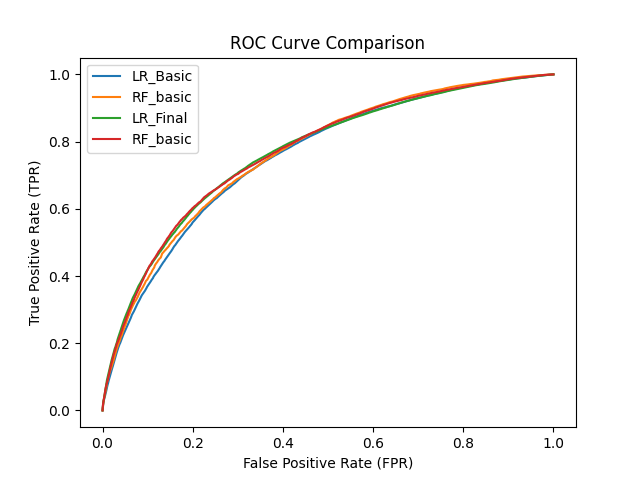

In [50]:
plt.clf()
lrfpr_basic = [item['FPR'] for item in lr_model_basic.summary.roc.select('FPR').collect()]
lrtpr_basic = [item['TPR'] for item in lr_model_basic.summary.roc.select('TPR').collect()]
plt.plot(lrfpr_basic, lrtpr_basic, label='LR_Basic')

rffpr_basic = [item['FPR'] for item in rf_model_basic.summary.roc.select('FPR').collect()]
rftpr_basic = [item['TPR'] for item in rf_model_basic.summary.roc.select('TPR').collect()]
plt.plot(rffpr_basic, rftpr_basic, label='RF_basic')

lrfpr = [item['FPR'] for item in lr_model.summary.roc.select('FPR').collect()]
lrtpr = [item['TPR'] for item in lr_model.summary.roc.select('TPR').collect()]
plt.plot(lrfpr, lrtpr, label='LR_Final')

rffpr = [item['FPR'] for item in rf_model.summary.roc.select('FPR').collect()]
rftpr = [item['TPR'] for item in rf_model.summary.roc.select('TPR').collect()]
plt.plot(rffpr, rftpr, label='RF_basic')

plt.title('ROC Curve Comparison')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend()

%matplot plt

### 7. Do Better

Now lets include more of the initial data that we originally cleaned out and see if we can do better!

In [51]:
from pyspark.sql.functions import mean

mean_value = df.filter(col('year') > 0).select(mean(col('year'))).collect()[0][0]
df_with_mean = df.withColumn('year', when(col('year') == 0, mean_value).otherwise(col('year')))

# mean_value = df_with_mean.filter(~isnan(col('artist_latitude'))).select(mean(col('artist_latitude'))).collect()[0][0]
# df_with_mean = df_with_mean.withColumn('artist_latitude', when(isnan(col('artist_latitude')), mean_value).otherwise(col('artist_latitude')))

# mean_value = df_with_mean.filter(~col('artist_longitude').isNull()).select(mean(col('artist_longitude'))).collect()[0][0]
# df_with_mean = df_with_mean.withColumn('artist_longitude', when(isnan(col('artist_longitude')), mean_value).otherwise(col('artist_longitude')))
                                 
                        
mean_value = df_with_mean.filter(~col('artist_latitude').isin(float('nan'))).select(mean(col('artist_latitude'))).collect()[0][0]
df_with_mean = df_with_mean.withColumn('artist_latitude', when(col('artist_latitude').isin(float('nan')), mean_value).otherwise(col('artist_latitude')))
                                
mean_value = df_with_mean.filter(~col('artist_longitude').isin(float('nan'))).select(mean(col('artist_longitude'))).collect()[0][0]
df_with_mean = df_with_mean.withColumn('artist_longitude', when(col('artist_longitude').isin(float('nan')), mean_value).otherwise(col('artist_longitude')))
                                    

cleaned_df = df_with_mean.filter(~isnan(df['artist_familiarity']))
cleaned_df = cleaned_df.filter(~isnan(df['title']))
cleaned_df = cleaned_df.filter(~isnull(df['title']))

average_hotttness = cleaned_df.select(avg('song_hotttnesss')).collect()[0][0]
df_with_label = cleaned_df.withColumn('label', when(col('song_hotttnesss') > average_hotttness, 1).otherwise(0))

min_year = df_with_label.select(min('year')).first()[0]
df_shifted_year = df_with_label.withColumn('year', col('year') - min_year)
df_shifted_year = df_shifted_year.drop("artist_location")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
for column in df_shifted_year.columns:
    nan_count = df_shifted_year.select(count(when(isnull(column), column))).collect()[0][0]
    print(f"NaN count for {column}: {nan_count}")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

NaN count for song_hotttnesss: 0
NaN count for artist_familiarity: 0
NaN count for artist_hotttnesss: 0
NaN count for artist_id: 0
NaN count for artist_latitude: 0
NaN count for artist_longitude: 0
NaN count for artist_name: 0
NaN count for title: 0
NaN count for danceability: 0
NaN count for duration: 0
NaN count for end_of_fade_in: 0
NaN count for energy: 0
NaN count for key: 0
NaN count for key_confidence: 0
NaN count for loudness: 0
NaN count for mode: 0
NaN count for mode_confidence: 0
NaN count for start_of_fade_out: 0
NaN count for tempo: 0
NaN count for time_signature: 0
NaN count for time_signature_confidence: 0
NaN count for artist_terms: 0
NaN count for artist_terms_freq: 0
NaN count for artist_terms_weight: 0
NaN count for year: 0
NaN count for label: 0

In [53]:
TF_IDF_NUM_FEATS = 8 # HashingTF(..., numFeatures=TF_IDF_NUM_FEATS)

tokenizer = Tokenizer(inputCol="title", outputCol="title_token")
token_df = tokenizer.transform(df_shifted_year)

hashing_tf = HashingTF(inputCol="title_token", outputCol="title_hash", numFeatures=TF_IDF_NUM_FEATS)
hashed_df = hashing_tf.transform(token_df)

idf = IDF(inputCol="title_hash", outputCol="title_features")
idf_model = idf.fit(hashed_df)
df_tf_idf = idf_model.transform(hashed_df)

tokenizer = Tokenizer(inputCol="artist_terms", outputCol="artist_token")
token_df = tokenizer.transform(df_tf_idf)

hashing_tf = HashingTF(inputCol="artist_token", outputCol="artist_hash", numFeatures=TF_IDF_NUM_FEATS)
hashed_df = hashing_tf.transform(token_df)

idf = IDF(inputCol="artist_hash", outputCol="artist_features")
idf_model = idf.fit(hashed_df)
df_final = idf_model.transform(hashed_df)

labels = df_final.select("label")
columns_to_drop = ["label", "artist_id", "artist_location", "artist_name", "title", "artist_terms", "artist_terms_freq", 
                   "artist_terms_weight", "song_hotttnesss", "title_token", 'title_hash', 'artist_token', "artist_hash"]
feature_columns = df_final.drop(*columns_to_drop).columns

assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')
df_assembled = assembler.transform(df_final)


scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
scaler_model = scaler.fit(df_assembled)
df_scaled_features = scaler_model.transform(df_assembled)

train_df, test_df = df_scaled_features.randomSplit([0.8, 0.2], seed=10605)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [54]:
final_rf = RandomForestClassifier(labelCol="label", featuresCol="scaled_features", maxDepth=10, numTrees=25)
final_rf_model = final_rf.fit(train_df)
final_rf_train_predictions = final_rf_model.transform(train_df)
final_rf_test_predictions = final_rf_model.transform(test_df)
final_rf_train_auc = auc_eval.evaluate(final_rf_train_predictions)
final_rf_test_auc = auc_eval.evaluate(final_rf_test_predictions)
final_rf_train_auc, final_rf_test_auc

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.7944492542170315, 0.7939192057400779)

Lets try the GBTClassifier from pyspark

In [61]:
from pyspark.ml.classification import GBTClassifier

final_rf = GBTClassifier(labelCol="label", featuresCol="scaled_features", maxDepth=12, maxIter=60)
final_rf_model = final_rf.fit(train_df)
final_rf_train_predictions = final_rf_model.transform(train_df)
final_rf_test_predictions = final_rf_model.transform(test_df)
final_rf_train_auc = auc_eval.evaluate(final_rf_train_predictions)
final_rf_test_auc = auc_eval.evaluate(final_rf_test_predictions)
final_rf_train_auc, final_rf_test_auc

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.9377632247952638, 0.8603280150788746)

We acheived a significantly higher AUC as compared to the simple models with less data. This shows the power of more data and the right models!